In [1]:
# BiLSTM-based Intrusion Detection on TON IoT Dataset (Rewritten)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split

# Load Dataset
df = pd.read_csv('../dataset/final_df.csv', low_memory=False)
print("Original DataFrame Head:\n", df.head())
print("\nOriginal Class Distribution:\n", df['type'].value_counts())
print("\nOriginal Label Distribution:\n", df['label'].value_counts())
print("\nOriginal Data Types:\n", df.dtypes)
print("\nOriginal Data Shapes:\n", df.shape)

# --- Data Preprocessing ---
# Clean and impute
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce').fillna(0)
df.drop_duplicates(inplace=True)

df.fillna(df.mean(numeric_only=True), inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True) # Or df[col].mode()[0]
        else:
            df[col].fillna(df[col].mean(), inplace=True)

print(f"Shape after handling NaNs: {df.shape}")

# Identify targets
TARGET_LABEL = 'label'
TARGET_TYPE = 'type'

# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_TYPE in categorical_cols:
    categorical_cols.remove(TARGET_TYPE)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded column: {col}")

# Normalize numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if TARGET_LABEL in numerical_cols:
    numerical_cols.remove(TARGET_LABEL)

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


2025-08-31 15:29:01.802026: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-31 15:29:02.190333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-31 15:29:03.753240: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Original DataFrame Head:
            ts         src_ip  src_port        dst_ip  dst_port proto service  \
0  1556499101  192.168.1.193     60396  192.168.1.33      8080   tcp       -   
1  1556494424  192.168.1.193     59273  192.168.1.33      8080   tcp       -   
2  1556487945  192.168.1.193     57717  192.168.1.33      8080   tcp       -   
3  1556508616  192.168.1.193     62682  192.168.1.33        80   tcp       -   
4  1556511697  192.168.1.193     63419  192.168.1.33      8080   tcp       -   

   duration src_bytes  dst_bytes  ... http_response_body_len  \
0  0.000180         0          0  ...                      0   
1  0.000111         0          0  ...                      0   
2  0.000148         0          0  ...                      0   
3  0.000127         0          0  ...                      0   
4  0.000122         0          0  ...                      0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                -          

In [2]:
binary_y = df[TARGET_LABEL].values
type_encoder = LabelEncoder()
y_multiclass_encoded = type_encoder.fit_transform(df[TARGET_TYPE])
# Convert to one-hot encoding for Keras if using categorical_crossentropy
y_multiclass_onehot = to_categorical(y_multiclass_encoded)

y_multiclass_labels = np.argmax(y_multiclass_onehot, axis=1)

# Drop targets from features
X = df.drop(columns=[TARGET_LABEL, TARGET_TYPE]).values
print("Feature shape (flat):", X.shape)
print("Binary target shape:", binary_y.shape)
print("Multi-class target shape:", y_multiclass_labels.shape)

# print the class distribution of binary_y and y_multiclass_labels
print("Binary target class distribution:")
print(Counter(binary_y))
print("Multi-class target class distribution:")
print(Counter(y_multiclass_labels))

Feature shape (flat): (441043, 44)
Binary target shape: (441043,)
Multi-class target shape: (441043,)
Binary target class distribution:
Counter({np.int64(0): 300000, np.int64(1): 141043})
Multi-class target class distribution:
Counter({np.int64(5): 300000, np.int64(0): 20000, np.int64(1): 20000, np.int64(2): 20000, np.int64(3): 20000, np.int64(6): 20000, np.int64(7): 20000, np.int64(8): 20000, np.int64(4): 1043})


In [3]:
# 1. Split BEFORE SMOTE (to avoid leakage)
# ----------------------------------------
X_train, X_test, \
y_train_binary, y_test_binary, \
y_train_multi, y_test_multi = train_test_split(
    X,
    binary_y,
    y_multiclass_labels,
    test_size=0.2,
    random_state=42,
    stratify=binary_y  # stratify on binary for this example
)

# Reset indices
X_train = pd.DataFrame(X_train).reset_index(drop=True).values
X_test = pd.DataFrame(X_test).reset_index(drop=True).values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_binary shape: {y_train_binary.shape}")
print(f"y_train_multiclass labels shape: {y_train_multi.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test_binary shape: {y_test_binary.shape}")
print(f"y_test_multiclass labels shape: {y_test_multi.shape}")

# print the class distribution of binary_y and y_multiclass
# print the class distribution of binary_y and y_multiclass
print("Binary target class distribution:")
print(Counter(y_train_binary))
print("Multi-class target class distribution:")
print(Counter(y_train_multi))
print("Binary target class distribution:")
print(Counter(y_test_binary))
print("Multi-class target class distribution:")
print(Counter(y_test_multi))

# scaling the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling complete.")


X_train shape: (352834, 44)
y_train_binary shape: (352834,)
y_train_multiclass labels shape: (352834,)
X_test  shape: (88209, 44)
y_test_binary shape: (88209,)
y_test_multiclass labels shape: (88209,)
Binary target class distribution:
Counter({np.int64(0): 240000, np.int64(1): 112834})
Multi-class target class distribution:
Counter({np.int64(5): 240000, np.int64(3): 16075, np.int64(0): 16049, np.int64(7): 16043, np.int64(1): 15999, np.int64(6): 15960, np.int64(2): 15940, np.int64(8): 15935, np.int64(4): 833})
Binary target class distribution:
Counter({np.int64(0): 60000, np.int64(1): 28209})
Multi-class target class distribution:
Counter({np.int64(5): 60000, np.int64(8): 4065, np.int64(2): 4060, np.int64(6): 4040, np.int64(1): 4001, np.int64(7): 3957, np.int64(0): 3951, np.int64(3): 3925, np.int64(4): 210})
Scaling complete.


In [4]:
# --- Create Sequences ---
def create_sequences(
    X,
    y,
    window_size: int = 10,
    debug: bool = False,
    trace_limit: int = 5
):
    # Convert to numpy if not already
    X = np.asarray(X)
    y = np.asarray(y)

    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if len(X.shape) != 2:
        raise ValueError("X must be a 2D array: (samples, features)")
    if len(y.shape) > 2:
        raise ValueError("y must be a 1D or 2D array")

    X_seq, y_seq = [], []
    total = len(X) - window_size + 1
    if debug:
        print(f"Total samples: {len(X)} | Generating {total} sequences (window_size={window_size})")

    for i in range(total):
        window = X[i : i + window_size]
        label = y[i + window_size - 1]
        X_seq.append(window)
        y_seq.append(label)

        if debug and i < trace_limit:
            print(f"\n--- Seq {i+1}/{total} ---")
            print(f"  X indices: {i} to {i+window_size-1}")
            print(f"  y index:   {i+window_size-1} → label={label}")
            print(f"  window.shape: {window.shape}")

    if debug:
        print(f"\nTotal sequences generated: {len(X_seq)}")

    return np.array(X_seq), np.array(y_seq)


TIMESTEPS = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train_binary, window_size=TIMESTEPS, debug=True)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_binary, window_size=TIMESTEPS, debug=True)


print("Train sequence shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("Test sequence shape:", X_test_seq.shape)
print("Binary target distribution:", Counter(y_train_binary))

# counters
print("Class distribution in y_train_seq:", Counter(y_train_seq))
print("Class distribution in y_test_seq:", Counter(y_test_seq))

# multiclass sequence generation.
# X_train_seq_multi, y_train_seq_multi = create_sequences(X_train, y_train_multi, debug=True)
# X_test_seq_multi, y_test_seq_multi = create_sequences(X_test, y_test_multi, debug=True)


Total samples: 352834 | Generating 352815 sequences (window_size=20)

--- Seq 1/352815 ---
  X indices: 0 to 19
  y index:   19 → label=0
  window.shape: (20, 44)

--- Seq 2/352815 ---
  X indices: 1 to 20
  y index:   20 → label=1
  window.shape: (20, 44)

--- Seq 3/352815 ---
  X indices: 2 to 21
  y index:   21 → label=1
  window.shape: (20, 44)

--- Seq 4/352815 ---
  X indices: 3 to 22
  y index:   22 → label=1
  window.shape: (20, 44)

--- Seq 5/352815 ---
  X indices: 4 to 23
  y index:   23 → label=1
  window.shape: (20, 44)

Total sequences generated: 352815
Total samples: 88209 | Generating 88190 sequences (window_size=20)

--- Seq 1/88190 ---
  X indices: 0 to 19
  y index:   19 → label=0
  window.shape: (20, 44)

--- Seq 2/88190 ---
  X indices: 1 to 20
  y index:   20 → label=0
  window.shape: (20, 44)

--- Seq 3/88190 ---
  X indices: 2 to 21
  y index:   21 → label=0
  window.shape: (20, 44)

--- Seq 4/88190 ---
  X indices: 3 to 22
  y index:   22 → label=0
  window.sha

In [5]:
from sklearn.utils import shuffle

# X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq_bal, y_train_seq_bal, random_state=42)
X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq, y_train_seq, random_state=42)

val_fraction = 0.2
n_total = X_train_seq_bal_shuffle.shape[0]
n_val = int(n_total * val_fraction)

X_val_seq = X_train_seq_bal_shuffle[-n_val:]
y_val_seq = y_train_seq_bal_shuffle[-n_val:]
X_train_seq_final = X_train_seq_bal_shuffle[:-n_val]
y_train_seq_final = y_train_seq_bal_shuffle[:-n_val]

print("Final training shapes:")
print(f"X_train_seq_final shape: {X_train_seq_final.shape}")
print(f"y_train_seq_final shape: {y_train_seq_final.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print("Final training label distributions:")
print(f"y_train_seq_final distribution: {Counter(y_train_seq_final)}")
print(f"y_val_seq distribution: {Counter(y_val_seq)}")

Final training shapes:
X_train_seq_final shape: (282252, 20, 44)
y_train_seq_final shape: (282252,)
X_val_seq shape: (70563, 20, 44)
y_val_seq shape: (70563,)
Final training label distributions:
y_train_seq_final distribution: Counter({np.int64(0): 192072, np.int64(1): 90180})
y_val_seq distribution: Counter({np.int64(0): 47912, np.int64(1): 22651})


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 20, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,433 (1.32 MB)

 Trainable params: 346,433 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-08-31 15:31:55.682192: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


4411/4411 ━━━━━━━━━━━━━━━━━━━━ 179s 39ms/step - accuracy: 0.7546 - auc: 0.9221 - loss: 1.0821 - precision: 0.5672 - recall: 0.9784 - val_accuracy: 0.9064 - val_auc: 0.9744 - val_loss: 0.4172 - val_precision: 0.7788 - val_recall: 0.9894 - learning_rate: 1.0000e-04
Epoch 2/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 173s 39ms/step - accuracy: 0.9203 - auc: 0.9798 - loss: 0.4658 - precision: 0.8062 - recall: 0.9883 - val_accuracy: 0.9455 - val_auc: 0.9892 - val_loss: 0.2335 - val_precision: 0.8624 - val_recall: 0.9879 - learning_rate: 1.0000e-04
Epoch 3/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 171s 39ms/step - accuracy: 0.9421 - auc: 0.9879 - loss: 0.3416 - precision: 0.8530 - recall: 0.9892 - val_accuracy: 0.9507 - val_auc: 0.9920 - val_loss: 0.1941 - val_precision: 0.8731 - val_recall: 0.9903 - learning_rate: 1.0000e-04
Epoch 4/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 165s 37ms/step - accuracy: 0.9510 - auc: 0.9910 - loss: 0.2915 - precision: 0.8740 - recall: 0.9892 - val_accuracy: 0.9645 - val_auc: 0.9943 - v

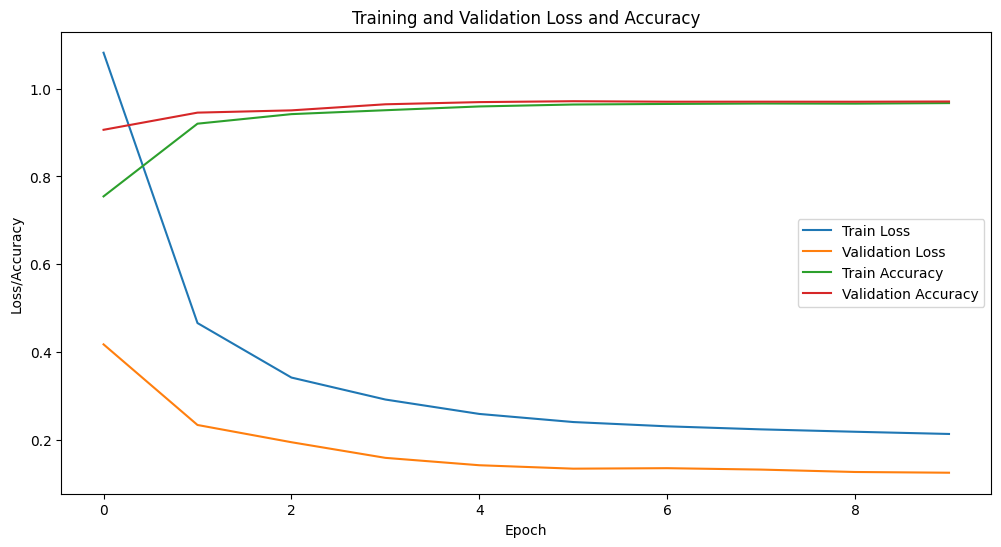

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step


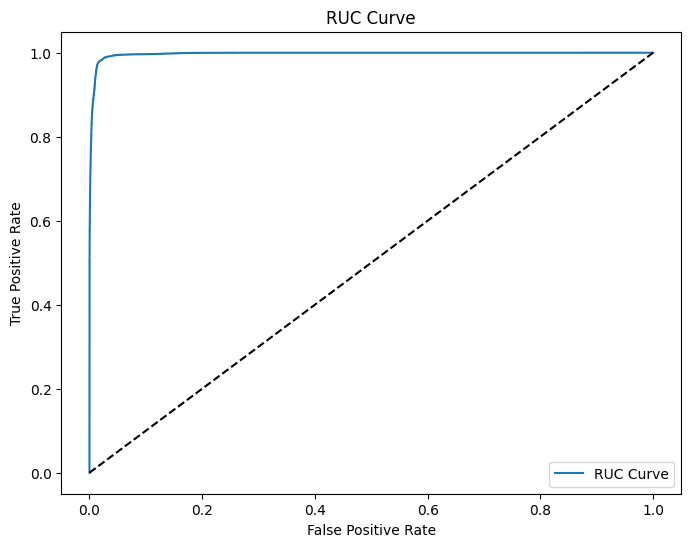

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step


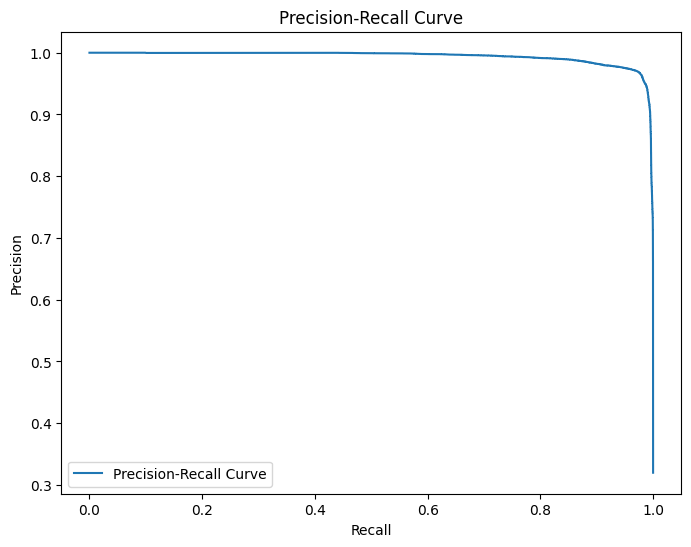

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    LayerNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])
model.summary()

optimizer = Adam(
    learning_rate=0.0001,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq_bal), y=y_train_seq_bal)
# class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict = {0: 1.0, 1: 10.0}


# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    # validation_split=0.2,
    epochs=10,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))

# Print classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32").flatten()
print(classification_report(y_test_seq, y_pred))

#confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)
print(cm)
# fnr and fpr
tn, fp, fn, tp = cm.ravel()
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
print("False Negative Rate (FNR):", fnr)
print("False Positive Rate (FPR):", fpr)

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# plot RUC curve
fpr, tpr, _ = roc_curve(y_test_seq, model.predict(X_test_seq).ravel())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='RUC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RUC Curve')
plt.legend()
plt.show()

# plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_seq, model.predict(X_test_seq).ravel())
plt.figure(figsize=(8, 6))  
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve') 
plt.legend()
plt.show()


In [10]:
# Hyperparameter Tuning with Bayesian Optimization (BayesSearchCV)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

def build_bilstm_model(
    lstm_units=64,
    hidden_layer=32,
    dropout=0.2,
    learning_rate=0.001,
    input_shape=(30, 44)
):
    model = Sequential([
        Bidirectional(LSTM(int(lstm_units*2), return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2), input_shape=input_shape),
        LayerNormalization(),
        Dropout(dropout),
        Bidirectional(LSTM(int(lstm_units))),
        LayerNormalization(),
        Dropout(dropout),
        Dense(int(hidden_layer), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

from sklearn.metrics import make_scorer

def constrained_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y_true, y_pred)
        # Constraints: FNR ≤ 0.01, FPR ≤ 0.5, Accuracy > 0.90
        if fnr <= 0.01 and fpr <= 0.5 and acc > 0.90:
            print(f"Valid model found: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return acc
        else:
            print(f"Model rejected: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return 0
    else:
        # If confusion matrix is not 2x2, return 0
        return 0

constrained_scorer = make_scorer(constrained_score)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq_bal), y=y_train_seq_bal)
# class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict = {0: 1.0, 1: 10.0}
# Wrap the model for scikit-learn compatibility
keras_clf = KerasClassifier(
    model=build_bilstm_model,
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Define the hyperparameter search space
param_space = {
    'model__lstm_units': Integer(64, 128),
    'model__hidden_layer': Integer(16, 32),
    'model__dropout': Real(0.2, 0.4),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'batch_size': Categorical([64, 128]),
    'epochs': Integer(5, 10)
}

opt = BayesSearchCV(
    estimator=keras_clf,
    search_spaces=param_space,
    n_iter=10,
    scoring=constrained_scorer,
    # cv=2,
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    refit=True
)

# Fit the optimizer (this may take a while)
opt.fit(X_train_seq_final, y_train_seq_final, callbacks=[early_stopping, reduce_lr], validation_split=0.2, class_weight=class_weight_dict)

print('Best parameters:', opt.best_params_)
print('Best cross-validation accuracy:', opt.best_score_)

# Evaluate on test set
test_score = opt.score(X_test_seq, y_test_seq)
print('Test set accuracy:', test_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 94s 38ms/step - accuracy: 0.8019 - loss: 1.0620 - val_accuracy: 0.8853 - val_loss: 0.3213
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.8800 - loss: 0.5145 - val_accuracy: 0.9110 - val_loss: 0.2885
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9125 - loss: 0.4022 - val_accuracy: 0.9359 - val_loss: 0.2422
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9344 - loss: 0.3260 - val_accuracy: 0.9236 - val_loss: 0.2300
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9415 - loss: 0.3069 - val_accuracy: 0.9505 - val_loss: 0.1727
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9444 - loss: 0.2979 - val_accuracy: 0.9626 - val_loss: 0.1566
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 38ms/step - accuracy: 0.9486 - loss: 0.2796 - val_accuracy: 0.9605 - val_loss: 0.1735
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 38ms/step - accuracy: 0.9464 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 92s 37ms/step - accuracy: 0.7958 - loss: 1.0813 - val_accuracy: 0.8296 - val_loss: 0.4310
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.8876 - loss: 0.4891 - val_accuracy: 0.9548 - val_loss: 0.1664
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9380 - loss: 0.3249 - val_accuracy: 0.9542 - val_loss: 0.1777
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9473 - loss: 0.2882 - val_accuracy: 0.9667 - val_loss: 0.1172
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9537 - loss: 0.2666 - val_accuracy: 0.9674 - val_loss: 0.1192
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9528 - loss: 0.2658 - val_accuracy: 0.9669 - val_loss: 0.1618
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9438 - loss: 0.3010 - val_accuracy: 0.9587 - val_loss: 0.1538
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 38ms/step - accuracy: 0.9466 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.7713 - loss: 0.8986 - val_accuracy: 0.9091 - val_loss: 0.3144
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9240 - loss: 0.3707 - val_accuracy: 0.9331 - val_loss: 0.2532
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9453 - loss: 0.2919 - val_accuracy: 0.9552 - val_loss: 0.2005
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9507 - loss: 0.2754 - val_accuracy: 0.9665 - val_loss: 0.1122
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9524 - loss: 0.2639 - val_accuracy: 0.9621 - val_loss: 0.1405
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 0.9527 - loss: 0.2746 - val_accuracy: 0.9719 - val_loss: 0.1126
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9554 - loss: 0.2561 - val_accuracy: 0.9650 - val_loss: 0.1287
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9459 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.8360 - loss: 0.6033 - val_accuracy: 0.9457 - val_loss: 0.2048
Epoch 2/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9368 - loss: 0.3057 - val_accuracy: 0.9487 - val_loss: 0.1856
Epoch 3/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9473 - loss: 0.2511 - val_accuracy: 0.9663 - val_loss: 0.1057
Epoch 4/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9562 - loss: 0.2205 - val_accuracy: 0.9677 - val_loss: 0.1022
Epoch 5/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9598 - loss: 0.2063 - val_accuracy: 0.9689 - val_loss: 0.1134
Epoch 6/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9616 - loss: 0.1965 - val_accuracy: 0.9701 - val_loss: 0.0838
Epoch 7/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9633 - loss: 0.1881 - val_accuracy: 0.9704 - val_loss: 0.0948
Epoch 8/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9643 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 52s 40ms/step - accuracy: 0.8422 - loss: 0.6025 - val_accuracy: 0.9481 - val_loss: 0.1794
Epoch 2/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9369 - loss: 0.3054 - val_accuracy: 0.9573 - val_loss: 0.1213
Epoch 3/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9466 - loss: 0.2555 - val_accuracy: 0.9664 - val_loss: 0.1199
Epoch 4/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9525 - loss: 0.2307 - val_accuracy: 0.9579 - val_loss: 0.1391
Epoch 5/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - accuracy: 0.9569 - loss: 0.2170 - val_accuracy: 0.9696 - val_loss: 0.1068
Epoch 6/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9615 - loss: 0.2018 - val_accuracy: 0.9726 - val_loss: 0.0957
Epoch 7/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9632 - loss: 0.1927 - val_accuracy: 0.9737 - val_loss: 0.0846
Epoch 8/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9644 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - accuracy: 0.8530 - loss: 0.5728 - val_accuracy: 0.9487 - val_loss: 0.1910
Epoch 2/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.9363 - loss: 0.3121 - val_accuracy: 0.9516 - val_loss: 0.1529
Epoch 3/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.9447 - loss: 0.2679 - val_accuracy: 0.9601 - val_loss: 0.1278
Epoch 4/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.9532 - loss: 0.2317 - val_accuracy: 0.9682 - val_loss: 0.1110
Epoch 5/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.9572 - loss: 0.2176 - val_accuracy: 0.9695 - val_loss: 0.1059
Epoch 6/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9600 - loss: 0.2033 - val_accuracy: 0.9656 - val_loss: 0.1130
Epoch 7/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.9614 - loss: 0.1952 - val_accuracy: 0.9675 - val_loss: 0.1116
Epoch 8/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.9643 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.6918 - loss: 1.0021 - val_accuracy: 0.7863 - val_loss: 0.5144
Epoch 2/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.8872 - loss: 0.4836 - val_accuracy: 0.9295 - val_loss: 0.2340
Epoch 3/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9274 - loss: 0.3390 - val_accuracy: 0.9429 - val_loss: 0.1866
Epoch 4/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9378 - loss: 0.2871 - val_accuracy: 0.9515 - val_loss: 0.1417
Epoch 5/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9491 - loss: 0.2452 - val_accuracy: 0.9626 - val_loss: 0.1444
Epoch 6/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9548 - loss: 0.2276 - val_accuracy: 0.9665 - val_loss: 0.1180
Epoch 7/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9579 - loss: 0.2137 - val_accuracy: 0.9689 - val_loss: 0.1025
Epoch 8/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9603 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.6902 - loss: 0.9987 - val_accuracy: 0.8381 - val_loss: 0.4213
Epoch 2/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.8720 - loss: 0.5233 - val_accuracy: 0.9064 - val_loss: 0.2562
Epoch 3/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9226 - loss: 0.3561 - val_accuracy: 0.9471 - val_loss: 0.1743
Epoch 4/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9388 - loss: 0.2867 - val_accuracy: 0.9627 - val_loss: 0.1131
Epoch 5/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9489 - loss: 0.2455 - val_accuracy: 0.9694 - val_loss: 0.1056
Epoch 6/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9556 - loss: 0.2243 - val_accuracy: 0.9678 - val_loss: 0.1154
Epoch 7/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9590 - loss: 0.2140 - val_accuracy: 0.9714 - val_loss: 0.1086
Epoch 8/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9617 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.6941 - loss: 0.9965 - val_accuracy: 0.8585 - val_loss: 0.3984
Epoch 2/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.8751 - loss: 0.5291 - val_accuracy: 0.9132 - val_loss: 0.2827
Epoch 3/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9125 - loss: 0.3859 - val_accuracy: 0.9330 - val_loss: 0.2069
Epoch 4/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9348 - loss: 0.3028 - val_accuracy: 0.9482 - val_loss: 0.1545
Epoch 5/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9480 - loss: 0.2551 - val_accuracy: 0.9623 - val_loss: 0.1275
Epoch 6/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9560 - loss: 0.2274 - val_accuracy: 0.9640 - val_loss: 0.1361
Epoch 7/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9598 - loss: 0.2113 - val_accuracy: 0.9665 - val_loss: 0.1173
Epoch 8/8
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.9624 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 57s 44ms/step - accuracy: 0.8099 - loss: 0.6827 - val_accuracy: 0.9420 - val_loss: 0.1937
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9354 - loss: 0.3192 - val_accuracy: 0.9489 - val_loss: 0.1568
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9452 - loss: 0.2690 - val_accuracy: 0.9570 - val_loss: 0.1339
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9520 - loss: 0.2397 - val_accuracy: 0.9533 - val_loss: 0.1467
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9549 - loss: 0.2249 - val_accuracy: 0.9686 - val_loss: 0.1007
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9581 - loss: 0.2122 - val_accuracy: 0.9669 - val_loss: 0.1116
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Valid model found: FNR=0.007218895542248836, FPR=0.043827314756966135, Acc=0.9678691382169126
[CV] END batch_size=128, epochs=6, model__dropout=0.3127559136780241, model__

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - accuracy: 0.8185 - loss: 0.6680 - val_accuracy: 0.9261 - val_loss: 0.2337
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.9355 - loss: 0.3070 - val_accuracy: 0.9619 - val_loss: 0.1297
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9481 - loss: 0.2529 - val_accuracy: 0.9618 - val_loss: 0.1268
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9544 - loss: 0.2320 - val_accuracy: 0.9711 - val_loss: 0.1056
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9567 - loss: 0.2215 - val_accuracy: 0.9729 - val_loss: 0.0928
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9592 - loss: 0.2123 - val_accuracy: 0.9714 - val_loss: 0.0931
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Valid model found: FNR=0.00801729873586161, FPR=0.04367112332875172, Acc=0.9677203350197696
[CV] END batch_size=128, epochs=6, model__dropout=0.3127559136780241, model__hi

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.8136 - loss: 0.6871 - val_accuracy: 0.9324 - val_loss: 0.2208
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.9335 - loss: 0.3182 - val_accuracy: 0.9495 - val_loss: 0.1441
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.9501 - loss: 0.2477 - val_accuracy: 0.9603 - val_loss: 0.1404
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.9562 - loss: 0.2221 - val_accuracy: 0.9679 - val_loss: 0.1062
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9579 - loss: 0.2154 - val_accuracy: 0.9656 - val_loss: 0.1256
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9603 - loss: 0.2084 - val_accuracy: 0.9707 - val_loss: 0.1009
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Valid model found: FNR=0.00801729873586161, FPR=0.04115644133449956, Acc=0.9694315717869139
[CV] END batch_size=128, epochs=6, model__dropout=0.3127559136780241, model__hi

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.8253 - loss: 0.6241 - val_accuracy: 0.9372 - val_loss: 0.2173
Epoch 2/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9305 - loss: 0.3359 - val_accuracy: 0.9521 - val_loss: 0.1620
Epoch 3/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9446 - loss: 0.2702 - val_accuracy: 0.9643 - val_loss: 0.1270
Epoch 4/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9521 - loss: 0.2386 - val_accuracy: 0.9670 - val_loss: 0.1074
Epoch 5/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9543 - loss: 0.2286 - val_accuracy: 0.9644 - val_loss: 0.1333
Epoch 6/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9550 - loss: 0.2205 - val_accuracy: 0.9611 - val_loss: 0.1146
Epoch 7/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 52ms/step - accuracy: 0.9577 - loss: 0.2133 - val_accuracy: 0.9642 - val_loss: 0.1157
736/736 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
Valid model found: FNR=0.006420492348636

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - accuracy: 0.8564 - loss: 0.5410 - val_accuracy: 0.9486 - val_loss: 0.1795
Epoch 2/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.9346 - loss: 0.3134 - val_accuracy: 0.9637 - val_loss: 0.1359
Epoch 3/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.9473 - loss: 0.2584 - val_accuracy: 0.9701 - val_loss: 0.1025
Epoch 4/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.9501 - loss: 0.2445 - val_accuracy: 0.9620 - val_loss: 0.1216
Epoch 5/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.9548 - loss: 0.2242 - val_accuracy: 0.9681 - val_loss: 0.1117
Epoch 6/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.9561 - loss: 0.2204 - val_accuracy: 0.9714 - val_loss: 0.1028
Epoch 7/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.9553 - loss: 0.2180 - val_accuracy: 0.9666 - val_loss: 0.1118
736/736 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
Valid model found: FNR=0.007451763140385

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.8617 - loss: 0.5603 - val_accuracy: 0.9469 - val_loss: 0.1609
Epoch 2/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9382 - loss: 0.2950 - val_accuracy: 0.9541 - val_loss: 0.1693
Epoch 3/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9487 - loss: 0.2529 - val_accuracy: 0.9525 - val_loss: 0.1636
Epoch 4/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9536 - loss: 0.2311 - val_accuracy: 0.9679 - val_loss: 0.1027
Epoch 5/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9566 - loss: 0.2198 - val_accuracy: 0.9705 - val_loss: 0.1074
Epoch 6/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9595 - loss: 0.2102 - val_accuracy: 0.9665 - val_loss: 0.1087
Epoch 7/7
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.9608 - loss: 0.2010 - val_accuracy: 0.9702 - val_loss: 0.1083
736/736 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
Valid model found: FNR=0.006852960745176

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 105s 43ms/step - accuracy: 0.8832 - loss: 0.4943 - val_accuracy: 0.9436 - val_loss: 0.1928
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9419 - loss: 0.2893 - val_accuracy: 0.9651 - val_loss: 0.1131
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - accuracy: 0.9480 - loss: 0.2564 - val_accuracy: 0.9643 - val_loss: 0.1284
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 410s 174ms/step - accuracy: 0.9529 - loss: 0.2327 - val_accuracy: 0.9646 - val_loss: 0.1236
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 410s 174ms/step - accuracy: 0.9580 - loss: 0.2131 - val_accuracy: 0.9671 - val_loss: 0.1152
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 411s 175ms/step - accuracy: 0.9589 - loss: 0.2029 - val_accuracy: 0.9684 - val_loss: 0.0976
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 411s 175ms/step - accuracy: 0.9612 - loss: 0.1936 - val_accuracy: 0.9681 - val_loss: 0.1029
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 121s 51ms/step - accuracy: 0.96

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 105s 43ms/step - accuracy: 0.8831 - loss: 0.4878 - val_accuracy: 0.9537 - val_loss: 0.1626
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9406 - loss: 0.2932 - val_accuracy: 0.9577 - val_loss: 0.1484
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9506 - loss: 0.2520 - val_accuracy: 0.9408 - val_loss: 0.1711
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9567 - loss: 0.2242 - val_accuracy: 0.9717 - val_loss: 0.1095
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9600 - loss: 0.2077 - val_accuracy: 0.9709 - val_loss: 0.1017
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9592 - loss: 0.2053 - val_accuracy: 0.9654 - val_loss: 0.1156
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9624 - loss: 0.1933 - val_accuracy: 0.9705 - val_loss: 0.0949
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9636 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 105s 43ms/step - accuracy: 0.8818 - loss: 0.4966 - val_accuracy: 0.9471 - val_loss: 0.1912
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9392 - loss: 0.2972 - val_accuracy: 0.9296 - val_loss: 0.1847
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9493 - loss: 0.2449 - val_accuracy: 0.9637 - val_loss: 0.1208
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9542 - loss: 0.2247 - val_accuracy: 0.9652 - val_loss: 0.1063
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9573 - loss: 0.2156 - val_accuracy: 0.9657 - val_loss: 0.1076
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9597 - loss: 0.2006 - val_accuracy: 0.9641 - val_loss: 0.1137
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9633 - loss: 0.1897 - val_accuracy: 0.9695 - val_loss: 0.1044
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9641 -

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 109s 44ms/step - accuracy: 0.8696 - loss: 0.5396 - val_accuracy: 0.9453 - val_loss: 0.1962
Epoch 2/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.9373 - loss: 0.3156 - val_accuracy: 0.9559 - val_loss: 0.1476
Epoch 3/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.9506 - loss: 0.2551 - val_accuracy: 0.9627 - val_loss: 0.1331
Epoch 4/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.9558 - loss: 0.2289 - val_accuracy: 0.9681 - val_loss: 0.1086
Epoch 5/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.9554 - loss: 0.2275 - val_accuracy: 0.9617 - val_loss: 0.1196
Epoch 6/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.9569 - loss: 0.2186 - val_accuracy: 0.9686 - val_loss: 0.1022
Epoch 7/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.9594 - loss: 0.2096 - val_accuracy: 0.9667 - val_loss: 0.1182
Epoch 8/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step - accuracy: 0.8691 - loss: 0.5402 - val_accuracy: 0.9481 - val_loss: 0.1856
Epoch 2/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9419 - loss: 0.2994 - val_accuracy: 0.9627 - val_loss: 0.1336
Epoch 3/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9490 - loss: 0.2661 - val_accuracy: 0.9593 - val_loss: 0.1250
Epoch 4/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9511 - loss: 0.2490 - val_accuracy: 0.9684 - val_loss: 0.1070
Epoch 5/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9553 - loss: 0.2269 - val_accuracy: 0.9716 - val_loss: 0.1095
Epoch 6/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9594 - loss: 0.2127 - val_accuracy: 0.9696 - val_loss: 0.1095
Epoch 7/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.9600 - loss: 0.2077 - val_accuracy: 0.9682 - val_loss: 0.1002
Epoch 8/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 105s 43ms/step - accuracy: 0.8646 - loss: 0.5339 - val_accuracy: 0.9474 - val_loss: 0.1708
Epoch 2/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9416 - loss: 0.2967 - val_accuracy: 0.9433 - val_loss: 0.2069
Epoch 3/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9508 - loss: 0.2591 - val_accuracy: 0.9623 - val_loss: 0.1490
Epoch 4/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9511 - loss: 0.2505 - val_accuracy: 0.9674 - val_loss: 0.1151
Epoch 5/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9545 - loss: 0.2356 - val_accuracy: 0.9690 - val_loss: 0.0980
Epoch 6/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9543 - loss: 0.2352 - val_accuracy: 0.9702 - val_loss: 0.0951
Epoch 7/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 101s 43ms/step - accuracy: 0.9550 - loss: 0.2276 - val_accuracy: 0.9589 - val_loss: 0.1255
Epoch 8/10
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.7769 - loss: 0.8254 - val_accuracy: 0.9186 - val_loss: 0.3004
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.9233 - loss: 0.3652 - val_accuracy: 0.9432 - val_loss: 0.1784
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9346 - loss: 0.3152 - val_accuracy: 0.9583 - val_loss: 0.1487
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9459 - loss: 0.2718 - val_accuracy: 0.9574 - val_loss: 0.1602
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9520 - loss: 0.2571 - val_accuracy: 0.9644 - val_loss: 0.1171
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9524 - loss: 0.2475 - val_accuracy: 0.9614 - val_loss: 0.1435
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Valid model found: FNR=0.006786427145708583, FPR=0.05199612645258028, Acc=0.9624484503209898
[CV] END batch_size=128, epochs=6, model__dropout=0.36558963717291976, model__

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.7742 - loss: 0.8598 - val_accuracy: 0.8853 - val_loss: 0.2929
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9128 - loss: 0.3911 - val_accuracy: 0.9513 - val_loss: 0.1750
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9494 - loss: 0.2647 - val_accuracy: 0.9688 - val_loss: 0.0999
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9578 - loss: 0.2309 - val_accuracy: 0.9694 - val_loss: 0.1018
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9573 - loss: 0.2276 - val_accuracy: 0.9706 - val_loss: 0.1084
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9603 - loss: 0.2172 - val_accuracy: 0.9631 - val_loss: 0.1379
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Valid model found: FNR=0.0064537591483699265, FPR=0.05688491815569162, Acc=0.9592279239828239
[CV] END batch_size=128, epochs=6, model__dropout=0.36558963717291976, model_

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.7562 - loss: 0.9397 - val_accuracy: 0.8741 - val_loss: 0.3236
Epoch 2/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.8894 - loss: 0.4264 - val_accuracy: 0.9467 - val_loss: 0.1845
Epoch 3/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9377 - loss: 0.3040 - val_accuracy: 0.9502 - val_loss: 0.1304
Epoch 4/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9469 - loss: 0.2524 - val_accuracy: 0.9652 - val_loss: 0.1138
Epoch 5/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9561 - loss: 0.2289 - val_accuracy: 0.9646 - val_loss: 0.1516
Epoch 6/6
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9611 - loss: 0.2127 - val_accuracy: 0.9696 - val_loss: 0.1097
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Valid model found: FNR=0.008083832335329342, FPR=0.04215606647507185, Acc=0.9687300710003827
[CV] END batch_size=128, epochs=6, model__dropout=0.36558963717291976, model__

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 96s 38ms/step - accuracy: 0.7973 - loss: 0.7129 - val_accuracy: 0.9246 - val_loss: 0.2318
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 38ms/step - accuracy: 0.9248 - loss: 0.3589 - val_accuracy: 0.9451 - val_loss: 0.1917
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 38ms/step - accuracy: 0.9406 - loss: 0.2971 - val_accuracy: 0.9622 - val_loss: 0.1357
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9471 - loss: 0.2741 - val_accuracy: 0.9625 - val_loss: 0.1266
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9530 - loss: 0.2607 - val_accuracy: 0.9656 - val_loss: 0.1237
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9517 - loss: 0.2624 - val_accuracy: 0.9586 - val_loss: 0.1395
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9511 - loss: 0.2547 - val_accuracy: 0.9577 - val_loss: 0.1552
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.9536 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 94s 38ms/step - accuracy: 0.8033 - loss: 0.8176 - val_accuracy: 0.9069 - val_loss: 0.2838
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9248 - loss: 0.3610 - val_accuracy: 0.9534 - val_loss: 0.1440
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9498 - loss: 0.2781 - val_accuracy: 0.9613 - val_loss: 0.1329
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9533 - loss: 0.2618 - val_accuracy: 0.9702 - val_loss: 0.1186
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9538 - loss: 0.2565 - val_accuracy: 0.9655 - val_loss: 0.1286
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9504 - loss: 0.2714 - val_accuracy: 0.9638 - val_loss: 0.1266
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9576 - loss: 0.2483 - val_accuracy: 0.9637 - val_loss: 0.1337
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 89s 38ms/step - accuracy: 0.9568 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 93s 37ms/step - accuracy: 0.8084 - loss: 0.7233 - val_accuracy: 0.8772 - val_loss: 0.2885
Epoch 2/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9246 - loss: 0.3440 - val_accuracy: 0.9532 - val_loss: 0.1718
Epoch 3/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9498 - loss: 0.2660 - val_accuracy: 0.9637 - val_loss: 0.1478
Epoch 4/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9513 - loss: 0.2613 - val_accuracy: 0.9662 - val_loss: 0.1178
Epoch 5/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9516 - loss: 0.2567 - val_accuracy: 0.9600 - val_loss: 0.1552
Epoch 6/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9544 - loss: 0.2510 - val_accuracy: 0.9638 - val_loss: 0.1334
Epoch 7/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9554 - loss: 0.2464 - val_accuracy: 0.9655 - val_loss: 0.1276
Epoch 8/9
2353/2353 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9558 - loss: 0

/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.8570 - loss: 0.5538 - val_accuracy: 0.9434 - val_loss: 0.2085
Epoch 2/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9362 - loss: 0.3057 - val_accuracy: 0.9488 - val_loss: 0.1586
Epoch 3/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9475 - loss: 0.2631 - val_accuracy: 0.9601 - val_loss: 0.1306
Epoch 4/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9516 - loss: 0.2368 - val_accuracy: 0.9617 - val_loss: 0.1232
Epoch 5/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9579 - loss: 0.2118 - val_accuracy: 0.9655 - val_loss: 0.1245
736/736 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
Valid model found: FNR=0.006121091151031271, FPR=0.045092465325502935, Acc=0.9673589558267081
[CV] END batch_size=128, epochs=5, model__dropout=0.3515766879791935, model__hidden_layer=31, model__learning_rate=0.001888036350634995, model__lstm_units=91; total time= 4.7min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - accuracy: 0.8605 - loss: 0.5514 - val_accuracy: 0.9551 - val_loss: 0.1514
Epoch 2/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 68s 57ms/step - accuracy: 0.9357 - loss: 0.3112 - val_accuracy: 0.9600 - val_loss: 0.1294
Epoch 3/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9509 - loss: 0.2502 - val_accuracy: 0.9644 - val_loss: 0.1210
Epoch 4/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9566 - loss: 0.2244 - val_accuracy: 0.9688 - val_loss: 0.1148
Epoch 5/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9594 - loss: 0.2108 - val_accuracy: 0.9705 - val_loss: 0.1047
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Valid model found: FNR=0.007817697937458417, FPR=0.04535799075346745, Acc=0.966636197440585
[CV] END batch_size=128, epochs=5, model__dropout=0.3515766879791935, model__hidden_layer=31, model__learning_rate=0.001888036350634995, model__lstm_units=91; total time= 5.0min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.8588 - loss: 0.5694 - val_accuracy: 0.9393 - val_loss: 0.2167
Epoch 2/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9279 - loss: 0.3478 - val_accuracy: 0.9457 - val_loss: 0.1755
Epoch 3/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9423 - loss: 0.2815 - val_accuracy: 0.9500 - val_loss: 0.1605
Epoch 4/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9523 - loss: 0.2384 - val_accuracy: 0.9667 - val_loss: 0.1177
Epoch 5/5
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9593 - loss: 0.2108 - val_accuracy: 0.9592 - val_loss: 0.1348
736/736 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Valid model found: FNR=0.006320691949434464, FPR=0.05646320129951268, Acc=0.9595574167764976
[CV] END batch_size=128, epochs=5, model__dropout=0.3515766879791935, model__hidden_layer=31, model__learning_rate=0.001888036350634995, model__lstm_units=91; total time= 4.7min


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - accuracy: 0.8795 - loss: 0.4949 - val_accuracy: 0.9461 - val_loss: 0.1840
Epoch 2/8
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.9487 - loss: 0.2519 - val_accuracy: 0.9648 - val_loss: 0.1269
Epoch 3/8
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.9586 - loss: 0.2141 - val_accuracy: 0.9677 - val_loss: 0.1141
Epoch 4/8
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.9615 - loss: 0.1988 - val_accuracy: 0.9697 - val_loss: 0.1051
Epoch 5/8
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.9649 - loss: 0.1857 - val_accuracy: 0.9677 - val_loss: 0.1132
Epoch 6/8
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.9669 - loss: 0.1774 - val_accuracy: 0.9749 - val_loss: 0.0825
Epoch 7/8
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.9672 - loss: 0.1747 - val_accuracy: 0.9713 - val_loss: 0.0956
Epoch 8/8
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 73s 41ms/step - accuracy: 0.9675 - loss: 0

Epoch 1/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 103s 45ms/step - accuracy: 0.9690 - loss: 0.1642 - val_accuracy: 0.9735 - val_loss: 0.0875 - learning_rate: 0.0016
Epoch 2/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 93s 42ms/step - accuracy: 0.9695 - loss: 0.1603 - val_accuracy: 0.9725 - val_loss: 0.0915 - learning_rate: 0.0016
Epoch 3/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 93s 42ms/step - accuracy: 0.9703 - loss: 0.1566 - val_accuracy: 0.9743 - val_loss: 0.0857 - learning_rate: 0.0016
Epoch 4/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 93s 42ms/step - accuracy: 0.9702 - loss: 0.1574 - val_accuracy: 0.9739 - val_loss: 0.0878 - learning_rate: 0.0016
Epoch 5/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 93s 42ms/step - accuracy: 0.9710 - loss: 0.1519 - val_accuracy: 0.9760 - val_loss: 0.0817 - learning_rate: 0.0016
Epoch 6/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 93s 42ms/step - accuracy: 0.9717 - loss: 0.1495 - val_accuracy: 0.9752 - val_loss: 0.0827 - learning_rate: 0.0016
Epoch 7/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 93s 42ms/step - accur

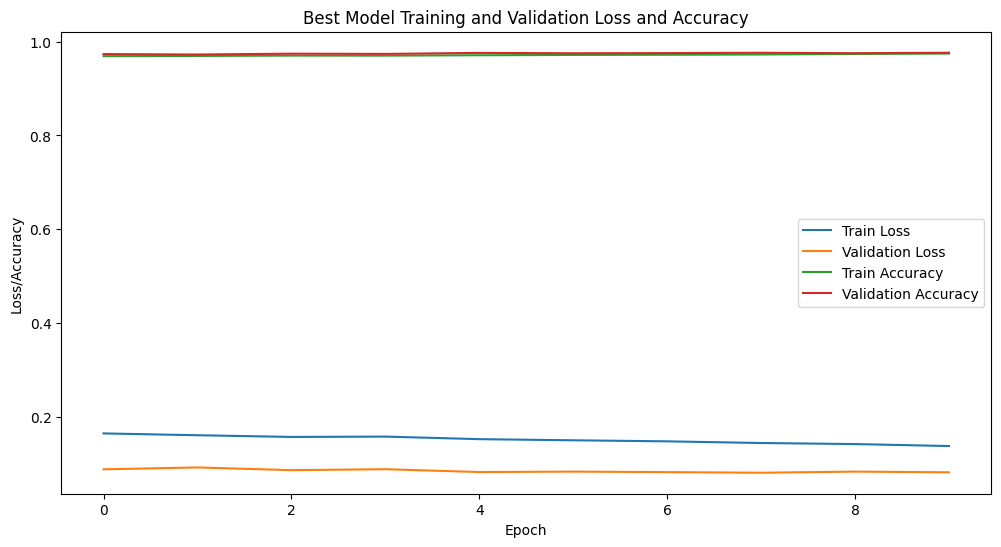

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step


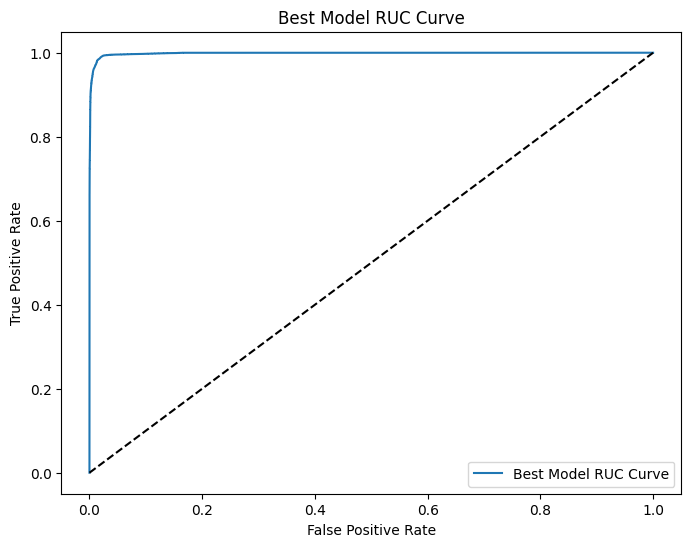

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step


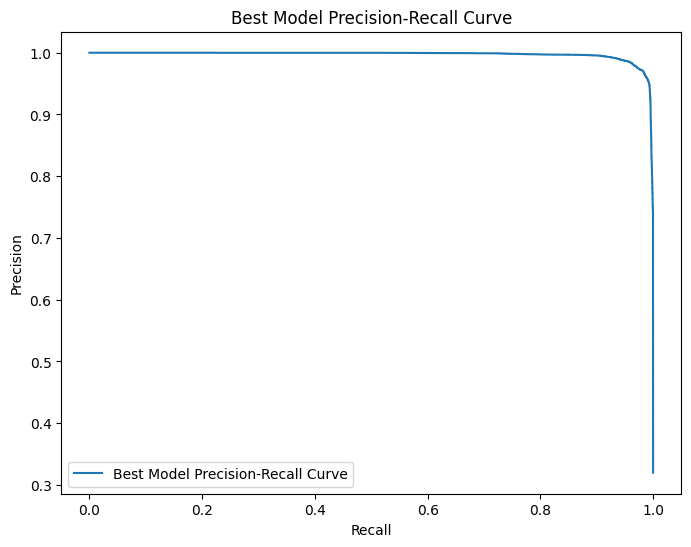

In [11]:
# train the model with best params
best_model = opt.best_estimator_.model_
history_best = best_model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=128,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# evaluate the best model
results_best = best_model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Best Model Test Loss: {}".format(results_best[0]))
print("Best Model Test Accuracy: {}".format(results_best[1]))

# calculate and print classification report for best model
y_pred_best = (best_model.predict(X_test_seq) > 0.5).astype("int32").flatten()
print(classification_report(y_test_seq, y_pred_best))
#confusion matrix for best model
cm_best = confusion_matrix(y_test_seq, y_pred_best)
print(cm_best)
# fnr and fpr for best model
tn, fp, fn, tp = cm_best.ravel()
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)
print("Best Model False Negative Rate (FNR):", fnr)
print("Best Model False Positive Rate (FPR):", fpr)

#plot validation loss and accuracy for best model
plt.figure(figsize=(12, 6))
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.plot(history_best.history['accuracy'], label='Train Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# plot the fnr vs fpr tarde off curve for best model 
fpr, tpr, _ = roc_curve(y_test_seq, best_model.predict(X_test_seq).ravel())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Best Model RUC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Model RUC Curve')
plt.legend()
plt.show()

# plot precision-recall curve for best model
precision, recall, _ = precision_recall_curve(y_test_seq, best_model.predict(X_test_seq).ravel())
plt.figure(figsize=(8, 6))  
plt.plot(recall, precision, label='Best Model Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Best Model Precision-Recall Curve') 
plt.legend()
plt.show()



2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step
Threshold: 0.01 | F1: 0.8498 | FNR: 0.0002 | FPR: 0.1661
Threshold: 0.02 | F1: 0.8521 | FNR: 0.0002 | FPR: 0.1630
Threshold: 0.03 | F1: 0.8534 | FNR: 0.0002 | FPR: 0.1613
Threshold: 0.04 | F1: 0.8545 | FNR: 0.0002 | FPR: 0.1600
Threshold: 0.05 | F1: 0.8552 | FNR: 0.0004 | FPR: 0.1590
Threshold: 0.06 | F1: 0.8559 | FNR: 0.0005 | FPR: 0.1579
Threshold: 0.07 | F1: 0.8568 | FNR: 0.0005 | FPR: 0.1569
Threshold: 0.08 | F1: 0.8573 | FNR: 0.0006 | FPR: 0.1561
Threshold: 0.09 | F1: 0.8578 | FNR: 0.0006 | FPR: 0.1555
Threshold: 0.10 | F1: 0.8585 | FNR: 0.0007 | FPR: 0.1545
Threshold: 0.11 | F1: 0.8591 | FNR: 0.0007 | FPR: 0.1537
Threshold: 0.12 | F1: 0.8655 | FNR: 0.0009 | FPR: 0.1456
Threshold: 0.13 | F1: 0.8944 | FNR: 0.0022 | FPR: 0.1097
Threshold: 0.14 | F1: 0.9250 | FNR: 0.0033 | FPR: 0.0744
Threshold: 0.15 | F1: 0.9411 | FNR: 0.0041 | FPR: 0.0567
Threshold: 0.16 | F1: 0.9497 | FNR: 0.0044 | FPR: 0.0475
Threshold: 0.17 | F1: 0.9534 | FNR: 0.0046 

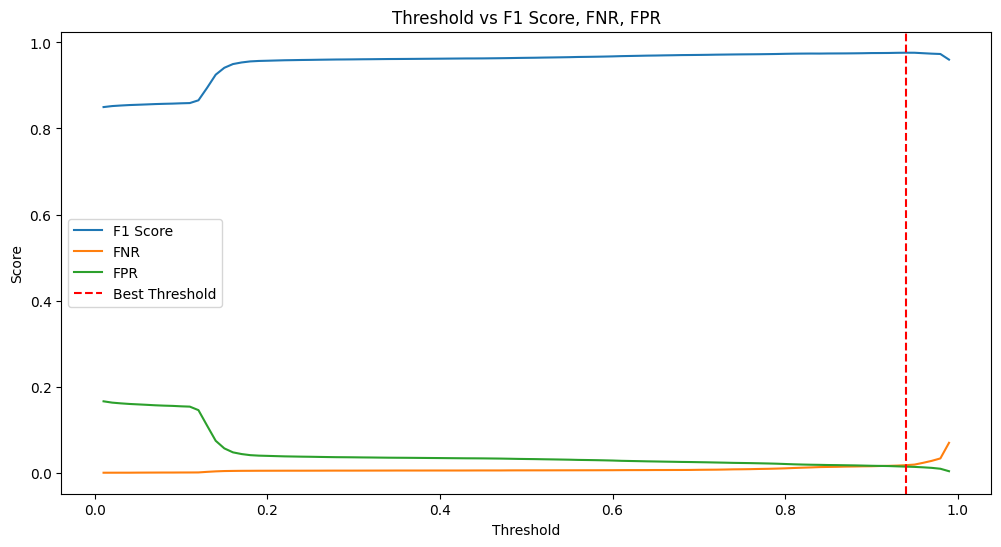

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59990
           1       0.97      0.98      0.98     28200

    accuracy                           0.98     88190
   macro avg       0.98      0.98      0.98     88190
weighted avg       0.98      0.98      0.98     88190

[[59130   860]
 [  499 27701]]
Best Model False Negative Rate (FNR): 0.01769503546099291
Best Model False Positive Rate (FPR): 0.014335722620436739


In [ ]:
# Get predicted probabilities
y_pred_probs = best_model.predict(X_test_seq).ravel()

# Try thresholds from 0.01 to 0.99
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []
fnr_list = []
fpr_list = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_probs > thresh).astype("int32")
    f1 = f1_score(y_test_seq, y_pred_thresh)
    cm = confusion_matrix(y_test_seq, y_pred_thresh)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        print(f"Threshold: {thresh:.2f} | F1: {f1:.4f} | FNR: {fnr:.4f} | FPR: {fpr:.4f}")
    else:
        fnr = fpr = 0
    f1_scores.append(f1)
    fnr_list.append(fnr)
    fpr_list.append(fpr)

# Find the best threshold
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Best threshold: {best_thresh:.2f} with F1-score: {f1_scores[best_idx]:.4f}")
print(f"FNR: {fnr_list[best_idx]:.4f}, FPR: {fpr_list[best_idx]:.4f}")

# plot the threshold graph
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, fnr_list, label='FNR')
plt.plot(thresholds, fpr_list, label='FPR')
plt.axvline(x=best_thresh, color='r', linestyle='--', label='Best Threshold')
plt.title('Threshold vs F1 Score, FNR, FPR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


In [14]:

# Use the best threshold for final predictions
best_thresh = 0.7
y_pred_best_thresh = (y_pred_probs > best_thresh).astype("int32")
print(classification_report(y_test_seq, y_pred_best_thresh))
cm_best = confusion_matrix(y_test_seq, y_pred_best_thresh)
print(cm_best)
if cm_best.shape == (2, 2):
    tn, fp, fn, tp = cm_best.ravel()
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    print("Best Model False Negative Rate (FNR):", fnr)
    print("Best Model False Positive Rate (FPR):", fpr)
else:
    print("Confusion matrix shape is not 2x2.")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     59990
           1       0.95      0.99      0.97     28200

    accuracy                           0.98     88190
   macro avg       0.97      0.98      0.98     88190
weighted avg       0.98      0.98      0.98     88190

[[58510  1480]
 [  196 28004]]
Best Model False Negative Rate (FNR): 0.006950354609929078
Best Model False Positive Rate (FPR): 0.024670778463077178


In [15]:
# Use the best threshold for final predictions
best_thresh = 0.78
y_pred_best_thresh = (y_pred_probs > best_thresh).astype("int32")
print(classification_report(y_test_seq, y_pred_best_thresh))
cm_best = confusion_matrix(y_test_seq, y_pred_best_thresh)
print(cm_best)
if cm_best.shape == (2, 2):
    tn, fp, fn, tp = cm_best.ravel()
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    print("Best Model False Negative Rate (FNR):", fnr)
    print("Best Model False Positive Rate (FPR):", fpr)
else:
    print("Confusion matrix shape is not 2x2.")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     59990
           1       0.96      0.99      0.97     28200

    accuracy                           0.98     88190
   macro avg       0.98      0.98      0.98     88190
weighted avg       0.98      0.98      0.98     88190

[[58690  1300]
 [  261 27939]]
Best Model False Negative Rate (FNR): 0.00925531914893617
Best Model False Positive Rate (FPR): 0.021670278379729953
